# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [ ]:
df = pd.read_csv("adult_data_train.csv", sep=",")

df = pd.DataFrame(df.drop(['education', 'marital-status'], axis=1))

In [ ]:
df

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,9,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Определите количество числовых и нечисловых признаков.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   fnlwgt          26048 non-null  int64 
 3   education-num   26048 non-null  int64 
 4   occupation      26048 non-null  object
 5   relationship    26048 non-null  object
 6   race            26048 non-null  object
 7   sex             26048 non-null  object
 8   capital-gain    26048 non-null  int64 
 9   capital-loss    26048 non-null  int64 
 10  hours-per-week  26048 non-null  int64 
 11  native-country  26048 non-null  object
 12  label           26048 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 2.6+ MB


Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

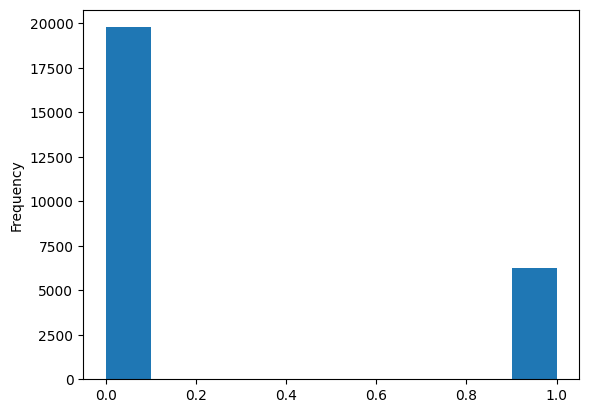

Сумма по классам  19775
Общее количество  26048
Доля  0.7591753685503686


In [ ]:
# Построение гистограммы
df['label'].plot.hist()

# Отображение гистограммы
plt.show()


print('Сумма по классам ', df[df['label']==0]['age'].count())
print('Общее количество ', df['age'].count())
print('Доля ', df[df['label']==0]['age'].count()/df['age'].count())

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных.

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [ ]:
X = df[['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']]

y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,stratify=y)

In [ ]:
X_train['fnlwgt'].mean()

190043.75909396296

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = neigh.predict(X_test)

In [ ]:
f1_score(y_test, y_pred)

0.3689119170984456

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [ ]:
from sklearn import preprocessing

# Выбираем один из вариантов стандартизации
stand_1 = preprocessing.MinMaxScaler()

# вычисляем параметры стандартизации (они сохраняются внутри объекта norm)
stand_1.fit(X_train)
# преобразуем данные
X_train_norm  = stand_1.transform(X_train)
# Получаем объект X -- матрицу класса numpy.ndarray.
# Преобразуем её в объект класса pandas.DataFrame.
X_train_norm = pd.DataFrame(X_train_norm, index= X_train.index, columns=X_train.columns)



# вычисляем параметры стандартизации (они сохраняются внутри объекта norm)
stand_1.fit(X_test)
# преобразуем данные
X_test_norm  = stand_1.transform(X_test)
# Получаем объект X -- матрицу класса numpy.ndarray.
# Преобразуем её в объект класса pandas.DataFrame.
X_test_norm = pd.DataFrame(X_test_norm, index= X_test.index, columns=X_test.columns)

In [ ]:
X_train_norm['fnlwgt'].mean()

0.1207255804009474

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = neigh.predict(X_test_norm)

f1_score(y_test, y_pred)

0.5103697024346258

Видно, что после линейной нормировки качество выросло.

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>).

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

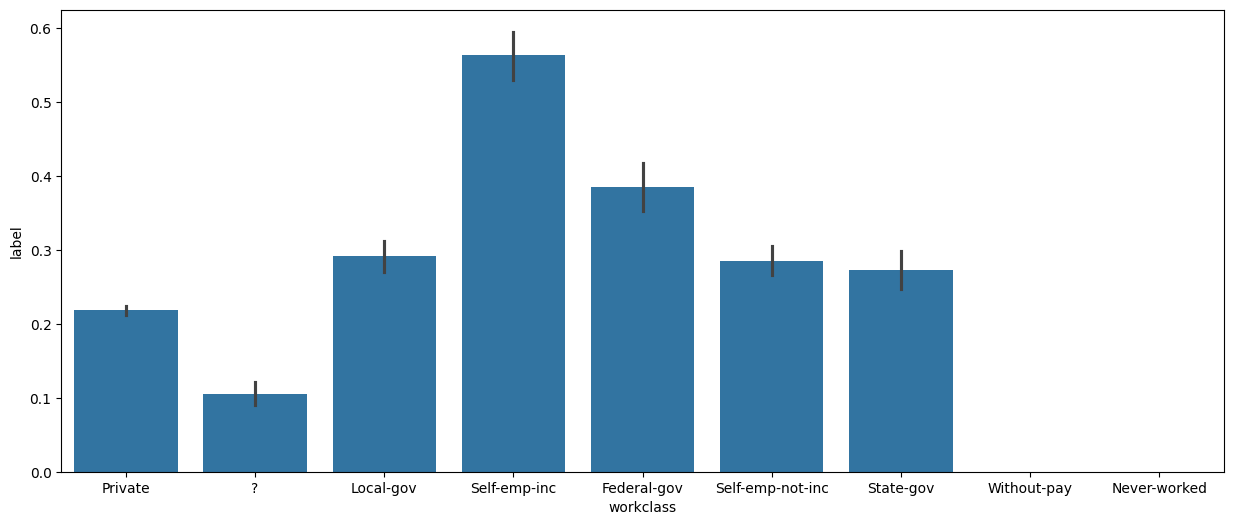

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15,6))
sns.barplot(x=df['workclass'], y=df['label']);

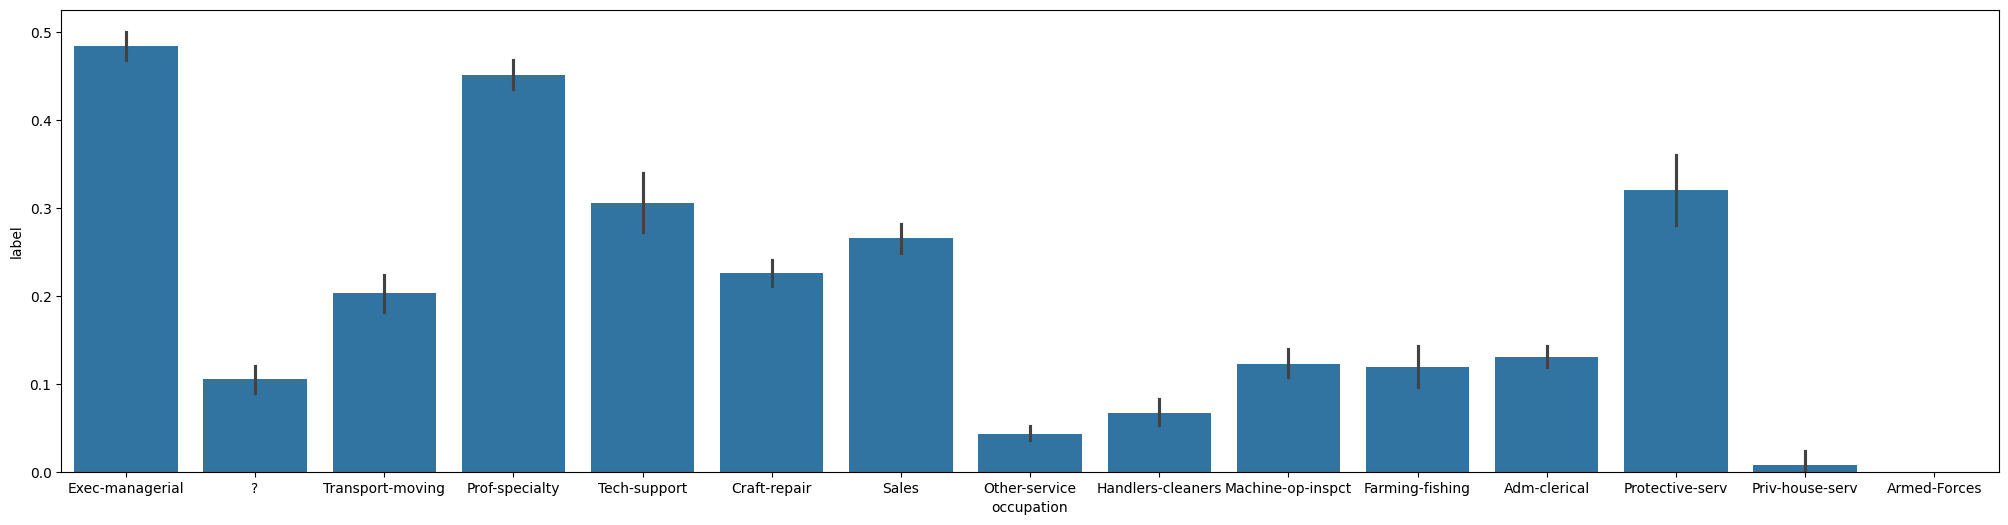

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(x=df['occupation'], y=df['label']);

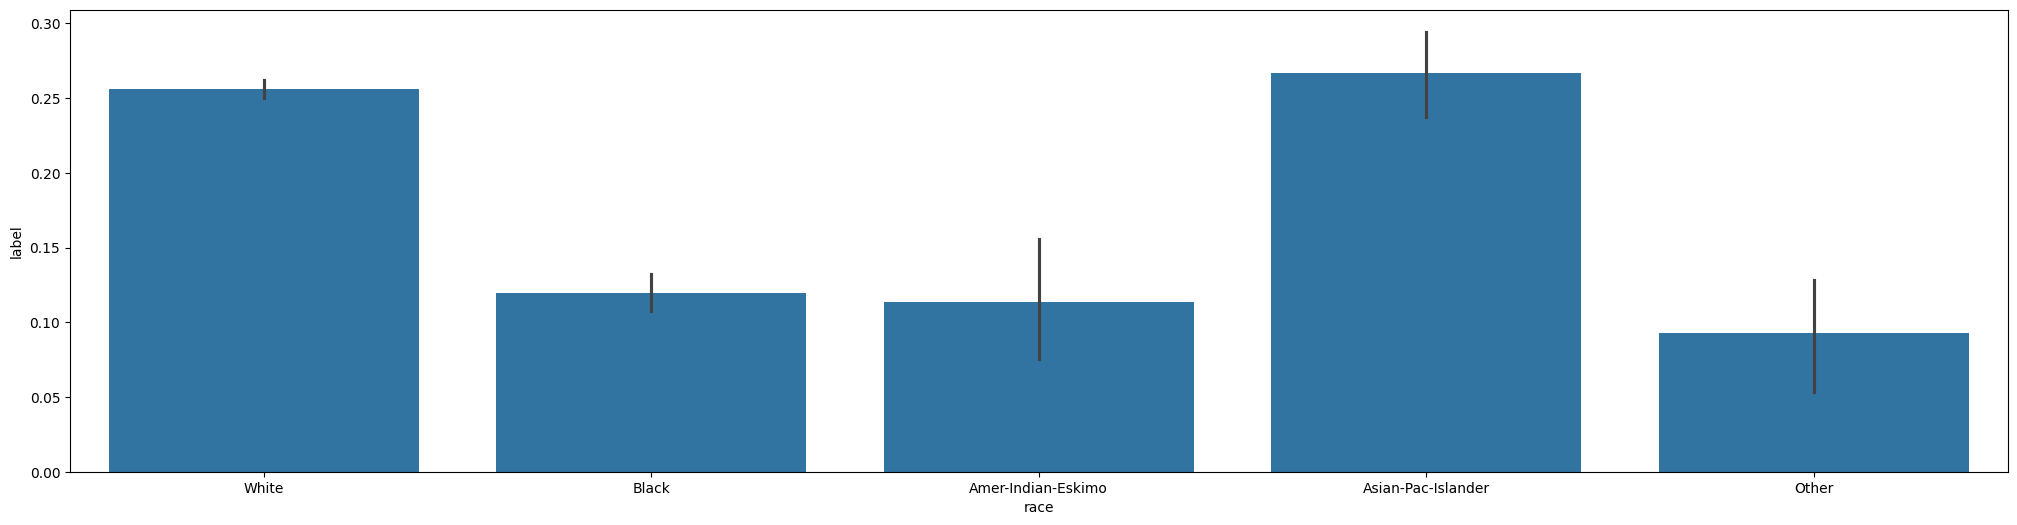

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(x=df['race'], y=df['label']);

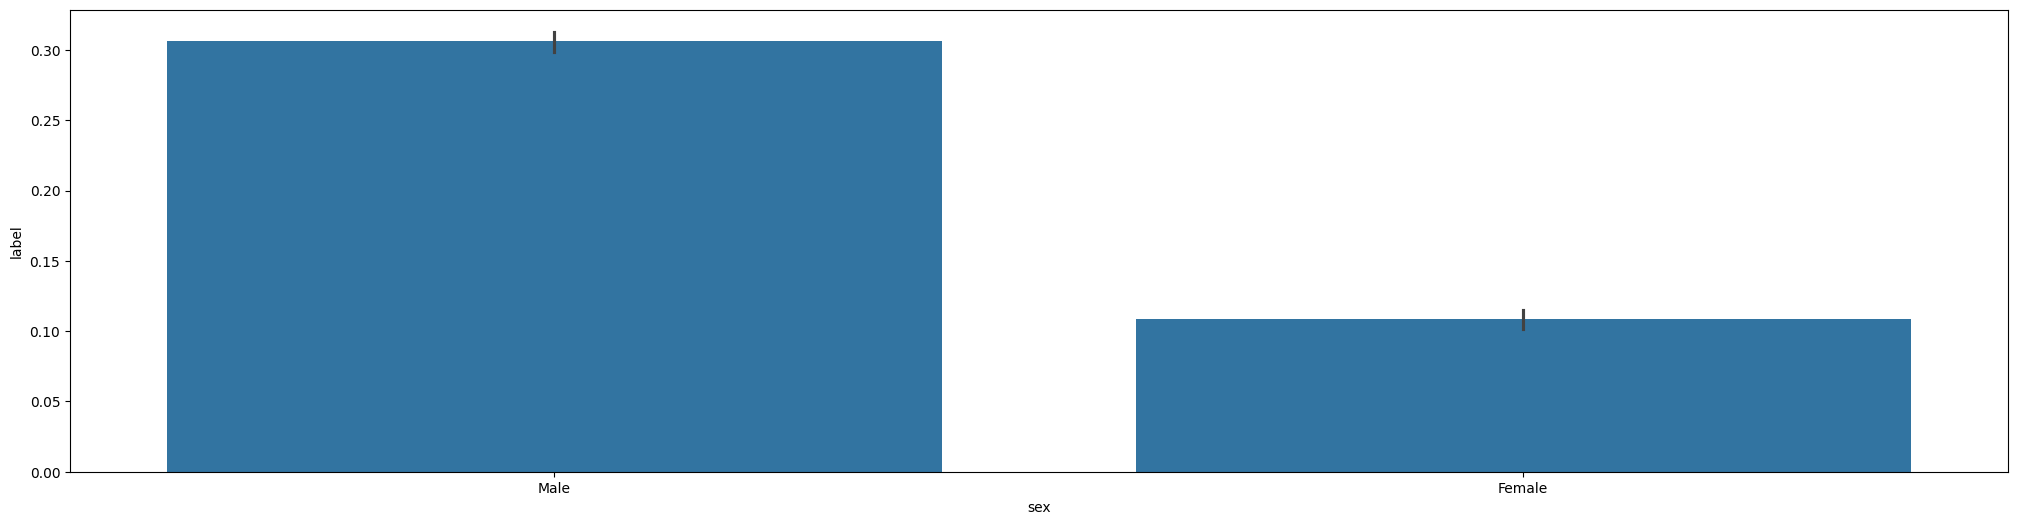

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(x=df['sex'], y=df['label']);

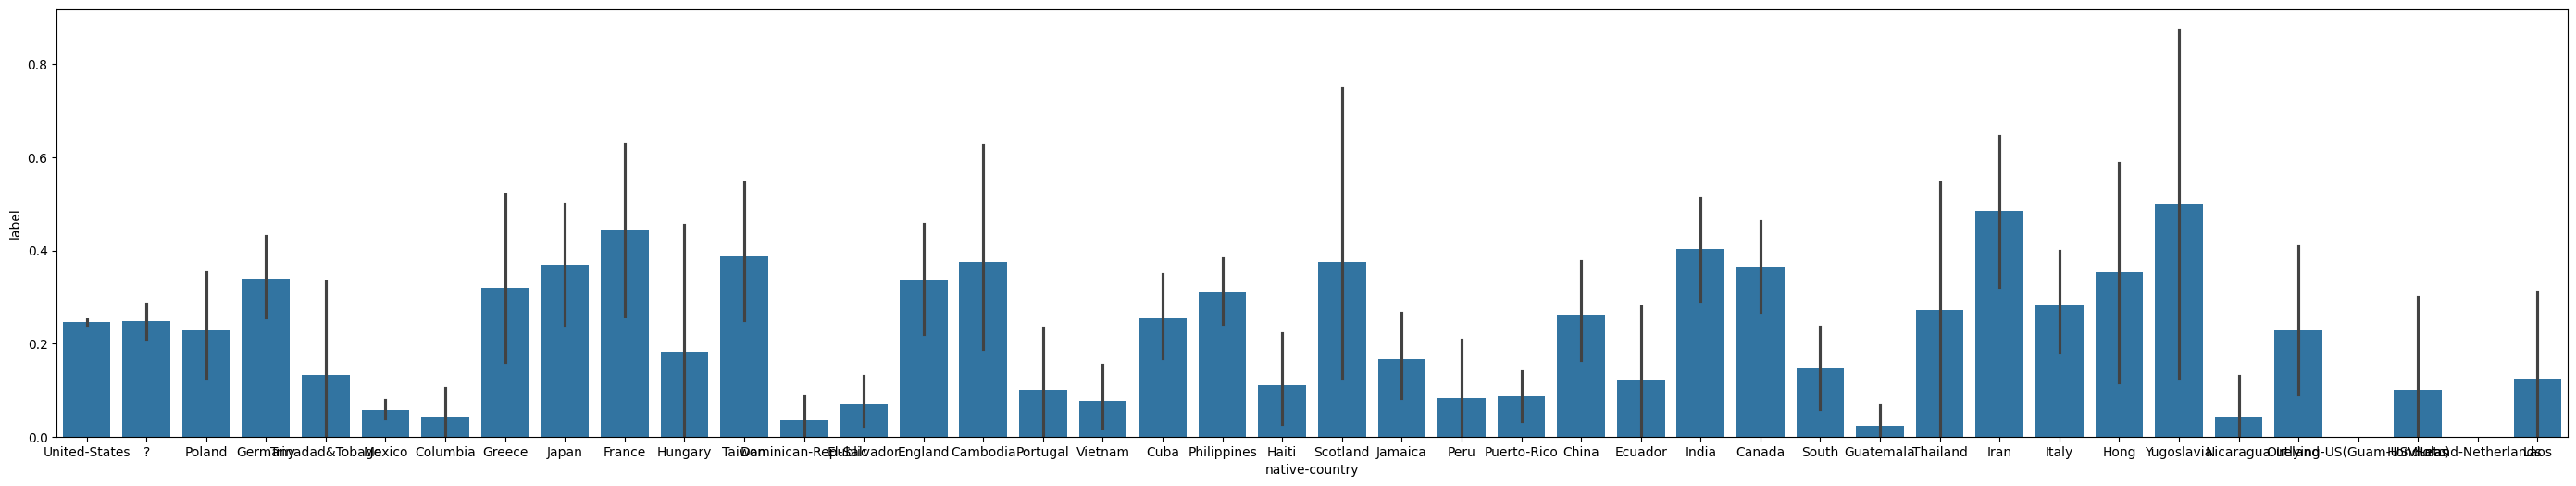

In [ ]:
plt.figure(figsize=(35,6))
sns.barplot(x=df['native-country'], y=df['label']);

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [ ]:
df = pd.read_csv("adult_data_train.csv", sep=",")

df = pd.DataFrame(df.drop(['education', 'marital-status'], axis=1))

In [ ]:
df

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,9,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [ ]:
df[(df['workclass']=='?')|(df['occupation']=='?')|(df['relationship']=='?')|(df['race']=='?')|(df['sex']=='?')|(df['native-country']=='?')].count()

,0
age,1914
workclass,1914
fnlwgt,1914
education-num,1914
occupation,1914
relationship,1914
race,1914
sex,1914
capital-gain,1914
capital-loss,1914


In [ ]:
df = df[(df['workclass']!='?')&(df['occupation']!='?')&(df['relationship']!='?')&(df['race']!='?')&(df['sex']!='?')&(df['native-country']!='?')]

Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них.

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [ ]:
df = pd.get_dummies(df, columns = df.select_dtypes(include=['object']).columns, drop_first=True)

In [ ]:
#X = df[['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']]
X = df.drop(['label'], axis = 1)#.drop(['label','age',	'fnlwgt',	'education-num',	'capital-gain',	'capital-loss',	'hours-per-week'], axis=1)
y = df['label']

In [ ]:
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,43,101950,14,0,0,45,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,40,24763,10,6849,0,40,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,24,113936,13,0,0,40,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
5,51,237630,9,7298,0,50,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
26044,39,421633,10,0,0,30,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
26045,55,82098,9,0,0,55,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
26046,26,50053,13,0,0,55,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,stratify=y)

In [ ]:
stand_1 = preprocessing.MinMaxScaler()

stand_1.fit(X_train)
X_train_norm  = stand_1.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index= X_train.index, columns=X_train.columns)


#stand_1.fit(X_test)
X_test_norm  = stand_1.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index= X_test.index, columns=X_test.columns)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = neigh.predict(X_test_norm)

f1_score(y_test, y_pred)

0.622733303847855

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.868     0.902     0.885      3626
           1      0.664     0.586     0.623      1201

    accuracy                          0.823      4827
   macro avg      0.766     0.744     0.754      4827
weighted avg      0.817     0.823     0.819      4827



In [ ]:
df = pd.read_csv("adult_data_train.csv", sep=",")

df = pd.DataFrame(df.drop(['education', 'marital-status'], axis=1))

In [ ]:
df = df[(df['workclass']!='?')&(df['occupation']!='?')&(df['relationship']!='?')&(df['race']!='?')&(df['sex']!='?')&(df['native-country']!='?')]

In [ ]:
df = pd.get_dummies(df, columns = df.select_dtypes(include=['object']).columns, drop_first=True)

In [ ]:
X = df[['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']]
X = df.drop(['label'], axis = 1)#.drop(['label','age',	'fnlwgt',	'education-num',	'capital-gain',	'capital-loss',	'hours-per-week'], axis=1)
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,stratify=y)

In [ ]:
from sklearn.decomposition import PCA

# Нормализация данных
scaler = preprocessing.StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Применение PCA для снижения размерности (если необходимо)
pca = PCA(n_components=0.95)  # Сохраняем 95% дисперсии
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)


In [ ]:
# Создание и обучение модели k-NN
model = KNeighborsClassifier()  # Можно изменить метрику
model.fit(X_train_pca, y_train)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test_pca)

# Оценка модели
f1 = f1_score(y_test, y_pred)
print(f'F1 Score на тестовых данных: {f1}')

F1 Score на тестовых данных: 0.6170500676589986


Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [ ]:
df = pd.read_csv("adult_data_train.csv", sep=",")

df = pd.DataFrame(df.drop(['education', 'marital-status'], axis=1))

In [ ]:
# Заменяем '?' на самое частое значение в каждом столбце
for column in df.columns:
    # Находим моду (самое частое значение) для столбца, игнорируя '?'
    mode = df[column][df[column] != '?'].mode()[0]
    # Заменяем '?' на моду
    df[column] = df[column].replace('?', mode)


Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
df

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,43,101950,14,0,0,45,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,20,122244,9,0,0,28,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
3,40,24763,10,6849,0,40,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,24,113936,13,0,0,40,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26044,39,421633,10,0,0,30,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
26045,55,82098,9,0,0,55,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
26046,26,50053,13,0,0,55,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
X = df.drop(['label'], axis = 1)#.drop(['label','age',	'fnlwgt',	'education-num',	'capital-gain',	'capital-loss',	'hours-per-week'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,stratify=y)

In [ ]:
stand_1 = preprocessing.MinMaxScaler()

# вычисляем параметры стандартизации (они сохраняются внутри объекта norm)
stand_1.fit(X_train)
# преобразуем данные
X_train_norm  = stand_1.transform(X_train)
# Получаем объект X -- матрицу класса numpy.ndarray.
# Преобразуем её в объект класса pandas.DataFrame.
X_train_norm = pd.DataFrame(X_train_norm, index= X_train.index, columns=X_train.columns)



# вычисляем параметры стандартизации (они сохраняются внутри объекта norm)
#stand_1.fit(X_test)
# преобразуем данные
X_test_norm  = stand_1.transform(X_test)
# Получаем объект X -- матрицу класса numpy.ndarray.
# Преобразуем её в объект класса pandas.DataFrame.
X_test_norm = pd.DataFrame(X_test_norm, index= X_test.index, columns=X_test.columns)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = neigh.predict(X_test_norm)

print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

0.6137610806247362
              precision    recall  f1-score   support

           0      0.871     0.902     0.886      3955
           1      0.653     0.579     0.614      1255

    accuracy                          0.824      5210
   macro avg      0.762     0.741     0.750      5210
weighted avg      0.818     0.824     0.821      5210



## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.

### Задание 3

In [ ]:
df = pd.read_csv("adult_data_train.csv", sep=",")

df = pd.DataFrame(df.drop(['education', 'marital-status'], axis=1))


In [ ]:
#df = df[(df['workclass']!='?')&(df['occupation']!='?')&(df['relationship']!='?')&(df['race']!='?')&(df['sex']!='?')&(df['native-country']!='?')]

In [ ]:
# Заменяем '?' на самое частое значение в каждом столбце
for column in df.columns:
    # Находим моду (самое частое значение) для столбца, игнорируя '?'
    mode = df[column][df[column] != '?'].mode()[0]
    # Заменяем '?' на моду
    df[column] = df[column].replace('?', mode)

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
X_train = df.drop(['label'], axis = 1)#.drop(['label','age',	'fnlwgt',	'education-num',	'capital-gain',	'capital-loss',	'hours-per-week'], axis=1)
y_train = df['label']

In [ ]:
stand_1 = preprocessing.MinMaxScaler()

# вычисляем параметры стандартизации (они сохраняются внутри объекта norm)
stand_1.fit(X_train)
# преобразуем данные
X_train_norm  = stand_1.transform(X_train)
# Получаем объект X -- матрицу класса numpy.ndarray.
# Преобразуем её в объект класса pandas.DataFrame.
X_train_norm = pd.DataFrame(X_train_norm, index= X_train.index, columns=X_train.columns)

In [ ]:
X_test = pd.read_csv("adult_data_reserved.csv", sep=",")

#X_test = pd.DataFrame(df.drop(['education', 'marital-status'], axis=1))

In [ ]:
# Заменяем '?' в тестовом наборе на самое частое значение в каждом столбце
for column in X_test.columns:
    mode = X_test[column][X_test[column] != '?'].mode()[0]
    X_test[column] = X_test[column].replace('?', mode)

# One-Hot кодирование для тестового набора данных
X_test = pd.get_dummies(X_test, drop_first=True)

# Убедимся, что столбцы совпадают
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Масштабирование тестового набора данных
X_test_norm = stand_1.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = neigh.predict(X_train_norm)

print(f1_score(y_train, y_pred))

0.7200887523468169


In [ ]:
y_pred = neigh.predict(X_test_norm)

In [ ]:
with open('predictions.txt', 'w') as f:
    f.write(f"{y_pred.tolist()}")

если убрать замену на часто встречающиеся значения в x_test, то 0.614663542015

если добавить удаление строк, у которых ?, то 0.617028380634

если добавить замену ? на строки с частым попаданием Ваш результат: 0.614663542015

если добавить удаление в строки test, то ошибка
